# Importación y preprocesamiento


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions

In [5]:
# Abrimos y ajustamos los datos para leerlos
datos_pacientes = pd.read_csv("Datos.csv",sep = ";")
datos_pacientes["Marca de tiempo"] = pd.to_datetime(datos_pacientes["Marca de tiempo"])
datos_operaciones = pd.read_csv("Datos operaciones origen urgencias.csv")

datos_operaciones = datos_operaciones.iloc[:,:5]
datos_operaciones = datos_operaciones.drop(datos_operaciones.columns[3],axis = 1)

In [6]:
#Estas son las áreas que aparecen en el diagrama entregado
areas_mapa_profe = ["URG101_003","DIV101_603","DIV101_604","DIV101_703","DIV102_203","DIV103_107","DIV103_204",
"DIV104_602","OPR101_011","OPR101_033","OPR102_001","OPR102_003","End"]

In [7]:
# Lo primero que haremos será filtrar los datos para obtener el nodo "Outisde"
filtro_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))
datos_pacientes.loc[filtro_fuera,"Area"] = "Outside"

In [8]:
#Eliminamos las filas donde el valor actual y el anterior corresponden al nodo outside, dejamos el primero,
#marcando así la entrada del paciente al nodo outside, pero solo una vez 
filtro_doble_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))&((~datos_pacientes["Area"].shift(1).isin(areas_mapa_profe)))
datos_pacientes = datos_pacientes[~filtro_doble_fuera]


In [9]:
datos_pacientes["Hora derivacion"] = datos_pacientes["Marca de tiempo"].shift(-1)
datos_pacientes["Estadia"] = datos_pacientes["Hora derivacion"]  - datos_pacientes["Marca de tiempo"]
datos_pacientes["Estadia"] = datos_pacientes["Estadia"]/np.timedelta64(1,"h")
datos_pacientes["Siguiente Área"] = datos_pacientes["Area"].shift(-1)

In [7]:
import pylab as pl

In [87]:
plt.style.use('ggplot')

Probabilidad de transición desde la sala de urgencias (DIV101_703)
Outside       34.680135
End           23.456790
DIV103_204    11.111111
DIV104_602     7.182941
DIV101_604     6.060606
DIV101_603     5.162738
DIV103_107     5.050505
DIV102_203     4.040404
OPR102_003     3.030303
OPR101_033     0.112233
OPR102_001     0.112233
Name: Siguiente Área, dtype: float64


Text(0.5, 0, 'Horas')

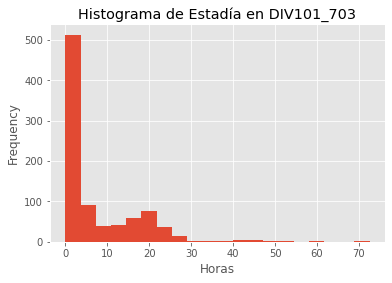

In [88]:
area = "DIV101_703"
derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
print(f"Probabilidad de transición desde la sala de urgencias ({area})")
transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
print(transiciones)
estadia_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
hist = estadia_urgencia.plot.hist(title = f"Histograma de Estadía en {area}",bins = 20)
hist.set_xlabel("Horas")

## Analizamos caso a a caso

In [8]:
set_pacientes = set(datos_pacientes["Case ID"])
entrada = "URG101_003"
salida = "End"
dic_info_pacientes = dict.fromkeys(set_pacientes,{})
for paciente in set_pacientes:
    info_paciente = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    hora_entrada = info_paciente.iloc[0]["Marca de tiempo"]
    hora_salida = info_paciente.iloc[-1]["Marca de tiempo"]
    dic_paciente ={"Entrada":hora_entrada,"Salida":hora_salida}
    duracion = hora_salida - hora_entrada
    dic_paciente["Duracion"] = duracion/np.timedelta64(1,"h")
    procedimiento = list(info_paciente["Area"])
    ruta = "".join(procedimiento)
    dic_paciente["Ruta"] = ruta
    dic_info_pacientes[paciente] = dic_paciente
    

In [9]:
df_info_pacientes = pd.DataFrame(dic_info_pacientes).T


# Estado actual de los KPI

### Lead time promedio

In [91]:
df_info_pacientes["Duracion"].mean()

81.9152056901192

### 5% de peores casos

In [92]:
duraciones = df_info_pacientes["Duracion"].sort_values()
n_5_peor = int(duraciones.shape[0]*0.05)
pct_5_peores_casos = duraciones.iloc[-n_5_peor:]
print(pct_5_peores_casos.mean())
print(pct_5_peores_casos.min())
print(pct_5_peores_casos.max())

971.1093023255813
453.93333333333334
4517.7


# Analizamos las llegadas

### Histograma de llegadas(solo para llegadas en menos de 24 horas)

Text(0.5, 1.0, 'Tiempo entre llegadas (Para tiempos menores a 24 horas)')

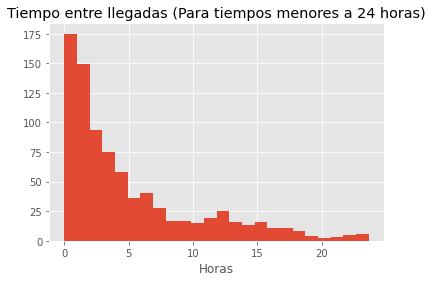

In [93]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
hist = tiempo_entre_llegadas[tiempo_entre_llegadas < 24].hist(bins = 24)
hist.set_xlabel("Horas")
hist.set_title("Tiempo entre llegadas (Para tiempos menores a 24 horas)")

,sumsquare_error,aic,bic,kl_div
halfcauchy,0.027976,820.437217,-8680.704904,inf
foldcauchy,0.028391,824.091098,-8661.541248,inf
powerlognorm,0.029278,807.510133,-8628.871488,inf
pareto,0.030699,807.311675,-8595.657400,inf
betaprime,0.031229,802.393090,-8574.490752,inf


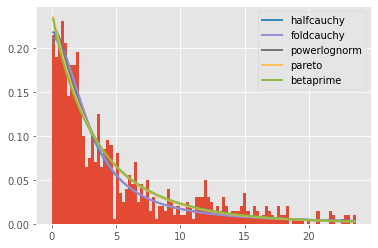

In [103]:
tiempo_filtrado = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
fit_llegadas_exp = Fitter(tiempo_filtrado)
fit_llegadas_exp.fit()
fit_llegadas_exp.summary()

,sumsquare_error,aic,bic,kl_div
expon,0.040003,796.096339,-8379.236682,inf


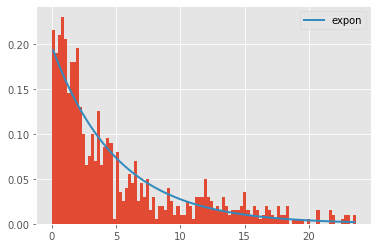

In [105]:
tiempo_filtrado = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
fit_llegadas_exp = Fitter(tiempo_filtrado, distributions=["expon"])
fit_llegadas_exp.fit()
fit_llegadas_exp.summary()

In [107]:
ajuste_exponencial = fit_llegadas_exp.get_best(method = "sumsquare_error")
ajuste_exponencial

{'expon': (0.0, 5.058066429418743)}

Text(0.5, 0, 'Hora del día')

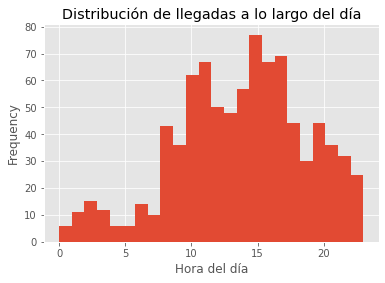

In [15]:
horas_entrada = [entrada.hour for entrada in df_info_pacientes["Entrada"]]
df_info_pacientes["Hora entrada"] = horas_entrada
hist = df_info_pacientes["Hora entrada"].plot.hist(bins = 24,title = "Distribución de llegadas a lo largo del día")
hist.set_xlabel("Hora del día")

# Analisis de operaciones

In [16]:
print(datos_operaciones["DURACION (hrs)"].mean())
print(datos_operaciones["DURACION (hrs)"].max())
print(datos_operaciones["DURACION (hrs)"].min())

2.4310679611650494
4.1
0.0


Text(0.5, 0, 'Horas')

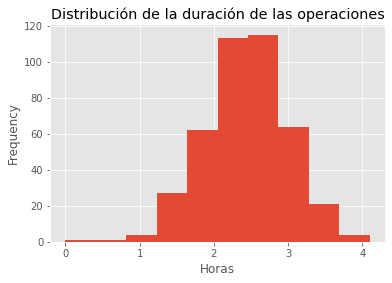

In [17]:
hist = datos_operaciones["DURACION (hrs)"].plot.hist()
hist.set_title("Distribución de la duración de las operaciones")
hist.set_xlabel("Horas")

Text(0.5, 1.0, 'Cantidad de operaciones recibidas por paciente')

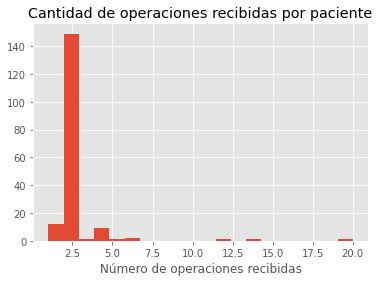

In [18]:
hist = datos_operaciones["ID"].value_counts().hist(bins = 20)
hist.set_xlabel("Número de operaciones recibidas")
hist.set_title("Cantidad de operaciones recibidas por paciente")

Text(0, 0.5, 'Número de operaciones realizadas')

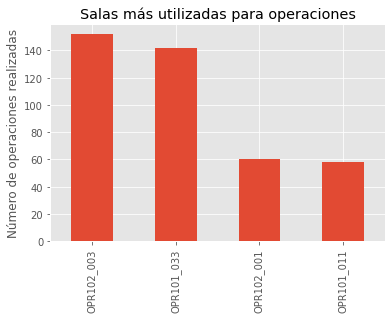

In [19]:
barplot = datos_operaciones["SALA OPERACIONES"].value_counts().plot.bar()
barplot.set_title("Salas más utilizadas para operaciones")
barplot.set_ylabel("Número de operaciones realizadas")

In [20]:
datos_operaciones

,ID,SALA OPERACIONES,FECHA E INICIO,DURACION (hrs)
0,14548704,OPR101_011,2018-01-02 10:15:00.000,2.8
1,14557024,OPR101_011,2017-12-22 13:37:00.000,1.6
2,14557024,OPR101_011,2018-01-12 15:36:00.000,1.2
3,14562339,OPR101_011,2018-01-03 15:56:00.000,1.3
4,14568735,OPR101_011,2018-01-05 18:34:00.000,3.2
...,...,...,...,...
407,14775043000,OPR102_003,2018-03-15 15:17:00.000,2.4
408,14799531000,OPR102_003,2018-03-26 13:02:00.000,3.3
409,14867095000,OPR102_003,2018-04-17 18:25:00.000,3.4
410,14973437000,OPR102_003,2018-05-30 13:42:00.000,2.4


In [21]:
areas_mapa_profe

['URG101_003',
 'DIV101_603',
 'DIV101_604',
 'DIV101_703',
 'DIV102_203',
 'DIV103_107',
 'DIV103_204',
 'DIV104_602',
 'OPR101_011',
 'OPR101_033',
 'OPR102_001',
 'OPR102_003',
 'End']

# Distribuciones por sala

In [10]:
from scipy import stats

In [23]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        f = Fitter(estadia,distributions = ["expon","beta","lognorm","norm",])
        f.fit()
        best = f.get_best(method = "sumsquare_error")
        dic_distribuciones[area] = best
        print(area,"lista")
    
    except:
        continue
        


URG101_003 lista
DIV101_603 lista
DIV101_604 lista
DIV101_703 lista
DIV102_203 lista
DIV103_107 lista
DIV103_204 lista
DIV104_602 lista
OPR101_011 lista
OPR101_033 lista
OPR102_001 lista


OPR102_003 lista


## Test de bondad 
Recordar que **si el p-value es menor a 0.05 implica que la distribución ajusta de buena manera a los datos**. Si el p-values es mayor a 0.05 significa que no hay información suficiente para justificar que la distribución ajusta de buena manera.

In [24]:
import math
for area in areas_mapa_profe:
    if area != 'End':
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        distribucion = list(dic_distribuciones[area].keys())[0]

        if distribucion == 'beta':
            param_a = dic_distribuciones[area]['beta'][0]
            param_b = dic_distribuciones[area]['beta'][1]
            loc = dic_distribuciones[area]['beta'][2]
            scale = dic_distribuciones[area]['beta'][3]
            esperado = (np.random.beta(a=param_a, b=param_b, size=len(estadia)) - loc) / scale

        elif distribucion == 'lognorm':
            s = dic_distribuciones[area]['lognorm'][0]
            loc = dic_distribuciones[area]['lognorm'][1]
            scale = dic_distribuciones[area]['lognorm'][2]
                
            esperado = (np.random.lognormal(mean=math.log(scale), sigma=s, size=len(estadia)) - loc) / scale

        else:
            print('Distribucion desconocida')

        test_bondad = stats.chisquare(f_obs = estadia, f_exp = esperado)
        print(area)
        resultado_test = list(test_bondad)
        print(f'Estadístico:{resultado_test[0]} p-value: {resultado_test[1]} \n')

URG101_003
Estadístico:12638078.850782946 p-value: 0.0 

DIV101_603
Estadístico:619327148948223.9 p-value: 0.0 

DIV101_604
Estadístico:1936609018192349.0 p-value: 0.0 

DIV101_703
Estadístico:1867711104957.9626 p-value: 0.0 

DIV102_203
Estadístico:4.560246072839681e+17 p-value: 0.0 

DIV103_107
Estadístico:231555664610548.38 p-value: 0.0 

DIV103_204
Estadístico:577668802390145.8 p-value: 0.0 

DIV104_602
Estadístico:1.4381354933849255e+20 p-value: 0.0 

OPR101_011
Estadístico:7241.892795703271 p-value: 0.0 

OPR101_033
Estadístico:-30534.52758811228 p-value: 1.0 

OPR102_001
Estadístico:-8383.142685368659 p-value: 1.0 

OPR102_003
Estadístico:275.9708010748603 p-value: 2.3152360752580137e-09 



In [25]:
dic_distribuciones

{'URG101_003': {'beta': (0.9963865319265526,
   7.549140779895584,
   -5.8548793004373246e-30,
   22.24393218386804)},
 'DIV101_603': {'beta': (0.3616704354973971,
   165.16296501053603,
   -7.412371308927781e-26,
   6922.807468149733)},
 'DIV101_604': {'beta': (0.45703588480386004,
   648.4486740488123,
   -8.513612931753873e-29,
   35054.048864844575)},
 'DIV101_703': {'beta': (0.5703786223184792,
   110.83109431271232,
   -1.462673655225481e-28,
   437.32033985936954)},
 'DIV102_203': {'beta': (0.24377071043553353,
   285.52176298361917,
   -1.187635564202615e-26,
   5018.705281761797)},
 'DIV103_107': {'beta': (0.39836402842306595,
   206.40113822847783,
   -1.5712666431312037e-28,
   10158.914732260619)},
 'DIV103_204': {'beta': (0.4888117957179907,
   109.8607935613231,
   -1.5936649681747108e-28,
   5313.91647884571)},
 'DIV104_602': {'beta': (0.15192779271070977,
   194.10258963560304,
   -5.156397043984947e-29,
   8814.947865303959)},
 'OPR101_011': {'beta': (0.580887388605725

In [26]:
dic_histogramas= {}

{'lognorm': (1.1325392177517544, -0.1631080499945431, 3.01277091110916)}


,sumsquare_error,aic,bic,kl_div
lognorm,0.033620,814.881030,-8519.048424,inf
chi2,0.037207,794.198271,-8433.592650,inf
beta,0.062616,758.059596,-7988.039146,inf
norm,0.228845,853.969495,-6908.970436,inf


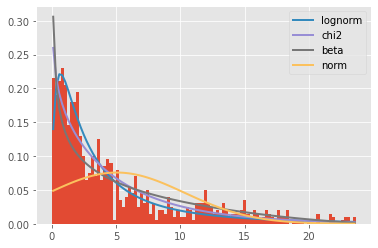

In [27]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
duracion_operaciones = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
duracion_operaciones = np.array(duracion_operaciones)
f = Fitter(duracion_operaciones,distributions = ["norm","beta","lognorm","chi2"])
f.fit()
a = f.get_best(method = "sumsquare_error")
print(a)
f.summary()


In [28]:
dic_histogramas["Tiempo_entre_llegadas"] = a

# Transiciones entre salas
Aqui se realiza un mapa de calor

In [29]:
df_heatmap = pd.DataFrame(index = areas_mapa_profe,columns = areas_mapa_profe)

In [30]:
areas_mapa_profe.append("Outside")

In [31]:
for area in areas_mapa_profe:
    derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
    transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
    df_heatmap[area] = transiciones

In [32]:
df_heatmap.fillna(0)

,URG101_003,DIV101_603,DIV101_604,DIV101_703,DIV102_203,DIV103_107,DIV103_204,DIV104_602,OPR101_011,OPR101_033,OPR102_001,OPR102_003,End,Outside
URG101_003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.510204,0.826446,1.724138,2.112676,0.000000,0.657895,99.88466,0.000000
DIV101_603,0.000000,0.000000,0.000000,5.162738,1.408451,1.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.654867
DIV101_604,0.000000,0.000000,0.000000,6.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.433628
DIV101_703,99.084668,0.000000,0.000000,0.000000,0.000000,0.000000,1.020408,0.826446,1.724138,12.676056,0.000000,1.315789,0.00000,0.221239
DIV102_203,0.114416,1.666667,0.000000,4.040404,0.000000,0.000000,0.000000,0.000000,48.275862,0.000000,1.666667,0.000000,0.00000,0.884956
DIV103_107,0.000000,1.666667,0.000000,5.050505,0.000000,0.000000,0.000000,0.000000,5.172414,0.000000,1.666667,0.000000,0.00000,0.442478
DIV103_204,0.000000,0.000000,0.000000,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,48.591549,0.000000,9.868421,0.00000,2.876106
DIV104_602,0.114416,0.000000,0.000000,7.182941,0.000000,0.000000,12.755102,0.000000,1.724138,7.746479,0.000000,1.973684,0.00000,3.539823
OPR101_011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826446,0.000000,0.000000,95.000000,0.000000,0.00000,0.000000
OPR101_033,0.000000,0.000000,0.000000,0.112233,0.000000,0.000000,4.591837,0.000000,0.000000,0.000000,0.000000,82.894737,0.00000,1.327434


<AxesSubplot:>

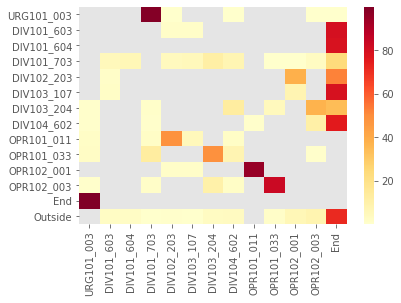

In [33]:
import seaborn as sns
sns.heatmap(df_heatmap.T,annot = False,cmap = "YlOrRd")

# Pacientes por día

In [34]:
salas_div  = areas_mapa_profe[:-5]

In [35]:
estadias_div = []
for paciente in set_pacientes :
    info_pacientes = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    info_hospitalizacion = info_pacientes[info_pacientes["Area"].isin(salas_div)]
    estadia = np.sum(info_pacientes["Estadia"])
    estadias_div.append(estadia)
estadia_serie = pd.Series(estadias_div)
estadia_serie = estadia_serie[(estadia_serie >0)]
print("Media de estadia en div (suma)",estadia_serie.mean())

Media de estadia en div (suma) 17.17735714285716


In [36]:
import datetime

In [37]:
def convertir_fecha(date):
    fecha = datetime.datetime.strftime(date,"%Y-%m-%d")
    return fecha

In [38]:
df_info_pacientes["Fecha_entrada"] = [convertir_fecha(df_info_pacientes["Entrada"].iloc[i]) for i in range(df_info_pacientes["Entrada"].shape[0])]

df_info_pacientes

,Entrada,Salida,Duracion,Ruta,Hora entrada,Fecha_entrada
14817280,2018-03-30 18:14:00,2018-03-30 22:06:00,3.866667,URG101_003DIV101_703DIV103_204End,18,2018-03-30
14931970,2018-05-13 16:37:00,2018-05-14 00:14:00,7.616667,URG101_003DIV101_703DIV102_203OPR102_001OPR101...,16,2018-05-13
14888963,2018-04-25 16:06:00,2018-04-26 12:26:00,20.333333,URG101_003DIV101_703OutsideEnd,16,2018-04-25
14696460,2018-02-15 12:04:00,2018-02-16 15:55:00,27.85,URG101_003DIV101_703DIV101_604End,12,2018-02-15
14579725,2018-01-04 21:05:00,2018-01-04 22:46:00,1.683333,URG101_003DIV101_703End,21,2018-01-04
...,...,...,...,...,...,...
14888950,2018-04-25 17:31:00,2018-05-15 14:18:00,476.783333,URG101_003DIV101_703OutsideDIV101_603End,17,2018-04-25
14682104,2018-02-08 14:27:00,2018-02-09 13:53:00,23.433333,URG101_003DIV101_703DIV104_602End,14,2018-02-08
14716923,2018-02-23 10:13:00,2018-02-23 18:39:00,8.433333,URG101_003DIV101_703End,10,2018-02-23
14716925,2018-02-23 17:47:00,2018-02-24 14:22:00,20.583333,URG101_003DIV101_703OutsideEnd,17,2018-02-23


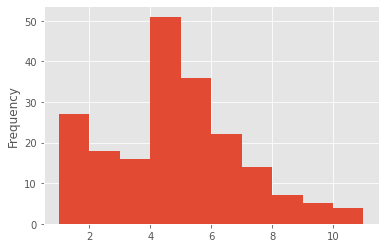

In [39]:
hist = df_info_pacientes["Fecha_entrada"].value_counts().plot.hist()


In [40]:
datos_atencion_urg = pd.read_csv("Datos_atencion_urg.csv")
ids_atencion = datos_atencion_urg["ID"]
set_atencion_urg = set(ids_atencion)
for paciente in set_pacientes:
    if paciente not in set_atencion_urg:
        print("Match")

Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Matc

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

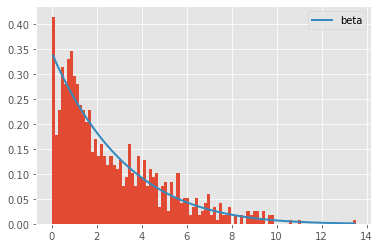

In [41]:
estadia = datos_pacientes[datos_pacientes["Area"] == "URG101_003"]["Estadia"]
estadia = np.array(estadia)
f = Fitter(estadia,distributions = ["beta"])
f.fit()
hist = f.summary()
plt.set_title("Estadia en URG101_003 distribución ajustada")
plt.set_xlabel("Horas")

In [ ]:
help(Fitter.summary)

# Ajuste de distribuciones de estadias OPR, DIV y URG

### Distribución Operaciones

In [10]:
print(f'Cantidad de datos de estadias en operaciones {len(datos_operaciones)}')
datos_operaciones['SALA OPERACIONES'].value_counts()

Cantidad de datos de estadias en operaciones 412


OPR102_003    152
OPR101_033    142
OPR102_001     60
OPR101_011     58
Name: SALA OPERACIONES, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x261a8e065e0>,
 'caps': [<matplotlib.lines.Line2D at 0x261a8bb2bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x261a8bb22b0>],
 'medians': [<matplotlib.lines.Line2D at 0x261a786ec10>],
 'fliers': [<matplotlib.lines.Line2D at 0x261a8c2efd0>],
 'means': []}

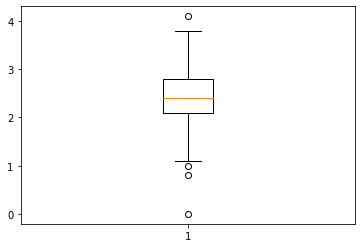

In [96]:
plt.boxplot(datos_operaciones['DURACION (hrs)'])

In [12]:
fit_operaciones = Fitter(datos_operaciones['DURACION (hrs)'])
fit_operaciones.fit()
fit_operaciones.summary()

KeyboardInterrupt: 

In [117]:
dic_distribuciones = {}
dic_distribuciones['OPR'] = fit_operaciones.get_best()
dic_distribuciones['OPR']

{'gennorm': (1.7513217591646353, 2.435311534067437, 0.7090240209156644)}

### Distribución DIVs

In [97]:
DIVs = ['DIV101_603', 'DIV101_604','DIV102_203','DIV103_107', 'DIV103_204', 'DIV104_602','DIV101_703']
DIV_101_703 = ['DIV101_703']
URGs = ['URG101_003']

In [180]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
estadias_div101_603 = np.array([])
estadias_div101_604 = np.array([])
estadias_div101_703 = np.array([])
estadias_div102_203 = np.array([])
estadias_div103_107 = np.array([])
estadias_div103_204 = np.array([])
estadias_div104_602 = np.array([])
estadias_urg = np.array([])

for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)

        if area == 'URG101_003':
            estadias_urg = np.append(estadias_urg, estadia)
        elif area == 'DIV101_603':
            estadias_div101_603 = np.append(estadias_div101_603, estadia)
        elif area == 'DIV101_604':
            estadias_div101_604 = np.append(estadias_div101_604, estadia)
        elif area == 'DIV101_703':
            estadias_div101_703 = np.append(estadias_div101_703, estadia)
        elif area == 'DIV102_203':
            estadias_div102_203 = np.append(estadias_div102_203, estadia)
        elif area == 'DIV103_107':
            estadias_div103_107 = np.append(estadias_div103_107, estadia)
        elif area == 'DIV103_204':
            estadias_div103_204 = np.append(estadias_div103_204, estadia)
        elif area == 'DIV104_602':
            estadias_div104_602 = np.append(estadias_div104_602, estadia)    
    
    except:
        print('Hubo un error')

estadias_div101_603 = estadias_div101_603[estadias_div101_603 != 0]
estadias_div101_604 = estadias_div101_604[estadias_div101_604 != 0]
estadias_div101_703 = estadias_div101_703[estadias_div101_703 != 0]
estadias_div102_203 = estadias_div102_203[estadias_div102_203 != 0]
estadias_div103_107 = estadias_div103_107[estadias_div103_107 != 0]
estadias_div103_204 = estadias_div103_204[estadias_div103_204 != 0]
estadias_div104_602 = estadias_div104_602[estadias_div104_602 != 0]

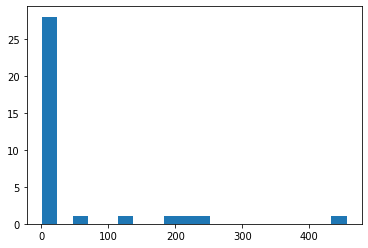

In [210]:
#plt.hist(estadias_div101_603, bins=20);
#plt.hist(estadias_div101_604, bins=20);
#plt.hist(estadias_div101_703, bins=20);
plt.hist(estadias_div102_203, bins=20);
#plt.hist(estadias_div103_107, bins=20);
#plt.hist(estadias_div103_204, bins=20);
#plt.hist(estadias_div104_602, bins=20);


# Datos estadias div: 37


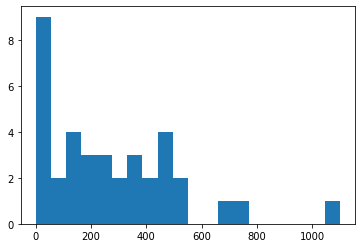

In [200]:
estadias_div_set_1 = np.array([])
estadias_div_set_1 = np.append(estadias_div_set_1, estadias_div101_603)
estadias_div_set_1 = np.append(estadias_div_set_1, estadias_div101_604)
estadias_div_set_1 = np.append(estadias_div_set_1, estadias_div103_107)

print(f'# Datos estadias div: {len(estadias_div_set_1)}')
plt.hist(estadias_div_set_1, bins=20);

(array([486.,  40.,  15.,   7.,  13.,   1.,   2.,   0.,   0.,   1.]),
 array([   0.        ,  110.05666667,  220.11333333,  330.17      ,
         440.22666667,  550.28333333,  660.34      ,  770.39666667,
         880.45333333,  990.51      , 1100.56666667]),
 <BarContainer object of 10 artists>)

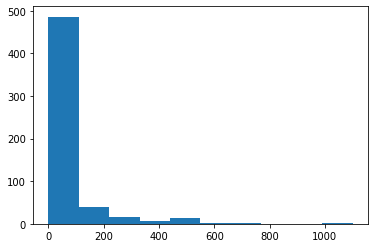

In [100]:
plt.hist(estadias_div)

0.25309734513274335


{'whiskers': [<matplotlib.lines.Line2D at 0x261abf12fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x261abf215b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x261abf12d00>],
 'medians': [<matplotlib.lines.Line2D at 0x261abf21b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x261abf21e20>],
 'means': []}

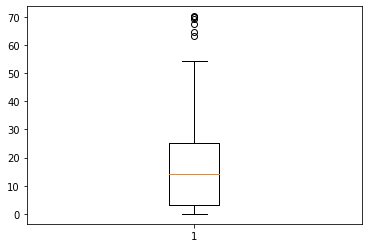

In [154]:
#plt.boxplot(estadias_urg)
s = np.std(estadias_div, ddof=1)
mu = np.mean(estadias_div)
iqr = stats.iqr(estadias_div)
cota_superior = stats.scoreatpercentile(estadias_div, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div, 75) - 1.5*iqr, 0)
cota_inferior = 0

estadias_div_filtrada = [x for x in estadias_div if cota_inferior < x <= cota_superior]

#iqr = stats.iqr(estadias_div_filtrada)
#cota_superior = stats.scoreatpercentile(estadias_div_filtrada, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div_filtrada, 75) - 3*iqr, 0)

#estadias_div_filtrada = [x for x in estadias_div_filtrada if cota_inferior < x <= cota_superior]

print(len(estadias_div_filtrada)/ len(estadias_div))
plt.boxplot(estadias_div_filtrada)

Como se puede ver, luego de aplicar un filtro sobre los strong outliers, nos quedamos con el 56% de los datos de estadias en los div ya que gran parte de ellos eran valores 0s que no tenien sentido dentro del contexto de nuestro problema.

,sumsquare_error,aic,bic,kl_div
exponpow,0.080507,790.276392,-594.325500,inf
lognorm,0.080781,815.074064,-594.029082,inf
gamma,0.080859,809.759742,-593.946002,inf
chi2,0.080859,809.760180,-593.945997,inf
cauchy,0.082898,885.369598,-596.244666,inf


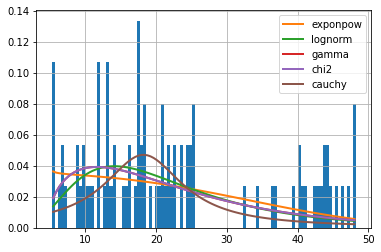

In [151]:
fit_divs = Fitter(estadias_div_filtrada, distributions = get_common_distributions())
fit_divs.fit()
fit_divs.summary()

,sumsquare_error,aic,bic,kl_div
lognorm,0.012522,1002.410960,-9025.015616,inf
gamma,0.015612,1066.589271,-8844.998717,inf
exponpow,0.023169,1034.092293,-8522.873753,inf
expon,0.027123,989.688119,-8400.997786,inf
powerlaw,0.028774,851.907825,-8346.090279,inf


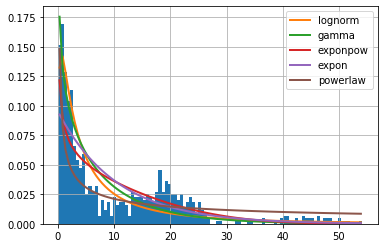

In [46]:
fit_common_divs = Fitter(estadias_div, distributions = get_common_distributions())
fit_common_divs.fit()
fit_common_divs.summary()

In [123]:
dic_distribuciones['DIV'] = fit_divs.get_best()
dic_distribuciones['DIV']

{'chi2': {'df': 1.7268846080592222,
  'loc': 0.016666666666236507,
  'scale': 9.340138195674726}}

In [124]:
dic_distribuciones['DIV'] = fit_divs.get_best()
df = dic_distribuciones['DIV']['chi2']['df']
loc = dic_distribuciones['DIV']['chi2']['loc']
scale = dic_distribuciones['DIV']['chi2']['scale']

(array([44., 12., 16., 15., 14.,  7.,  1.,  3.,  7., 12.]),
 array([1.66666667e-02, 4.84166667e+00, 9.66666667e+00, 1.44916667e+01,
        1.93166667e+01, 2.41416667e+01, 2.89666667e+01, 3.37916667e+01,
        3.86166667e+01, 4.34416667e+01, 4.82666667e+01]),
 <BarContainer object of 10 artists>)

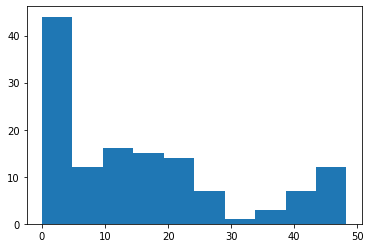

In [125]:
plt.hist(estadias_div_filtrada)

In [135]:
c1, c2, c3, c4, c5, c6 = 0, 0, 0, 0, 0, 0
clases_div = [(0,30), (6,24), (24,28), (28,32), (32,39), (39,58)]

for estadia in estadias_div:
    if estadia <= 30:
        c1 += 1
    
    elif estadia > 30 and estadia <= 24:
        c2 += 1

    elif estadia > 24 and estadia <= 28:
        c3 += 1
    
    elif estadia > 28 and estadia <= 32:
        c4 += 1
    
    elif estadia > 32 and estadia <= 39:
        c5 += 1
    
    elif estadia > 39 and estadia <= 58:
        c6 += 1

clases_div_freq = [c1, c2, c3, c4, c5, c6]

data_test_div = {
    'clases': clases_div,
    'observed_freq': clases_div_freq }

df_test_div = pd.DataFrame(data_test_div)

prob_dist = []
params_div = dic_distribuciones['DIV']['chi2']

for i in range(0,len(df_test_div)):
    rango_inferior = df_test_div['clases'].iloc[i][0]
    rango_superior = df_test_div['clases'].iloc[i][1]
    prob = stats.chi2.cdf(rango_superior, df=df, loc=loc, scale=scale) - stats.chi2.cdf(rango_inferior, df=df, loc=loc, scale=scale)
    prob_dist.append(prob)

df_test_div['prob_dist'] = prob_dist 
df_test_div['prob_dist'] = df_test_div['prob_dist'] / df_test_div['prob_dist'].sum()
df_test_div['expected_freq'] = df_test_div['observed_freq'].sum() * df_test_div['prob_dist']
df_test_div

,clases,observed_freq,prob_dist,expected_freq
0,"(0, 30)",443,0.572858,269.815905
1,"(6, 24)",0,0.294746,138.825490
2,"(24, 28)",0,0.031720,14.939943
3,"(28, 32)",0,0.025107,11.825605
4,"(32, 39)",4,0.032135,15.135508
5,"(39, 58)",24,0.043434,20.457549


In [128]:
df_test_div['prob_dist'].sum()

1.0

In [132]:
stats.chisquare(df_test_div['observed_freq'], f_exp = df_test_div['expected_freq'])

Power_divergenceResult(statistic=445.93039008214254, pvalue=3.7075240638380874e-94)

In [70]:
# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
for i in range(0, len(df_test_div)):
    O = df_test_div['observed_freq'].iloc[i]
    E = df_test_div['expected_freq'].iloc[i]
    resultado = (O-E)**2 /E
    chi_square += resultado

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, len(df_test_div['clases']) - 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 116.26874335694052  and p value is: 0.0
Null Hypothesis is rejected.


### Distribución URGs

In [137]:
np.mean(estadias_urg)

4.912511803588291

{'whiskers': [<matplotlib.lines.Line2D at 0x1c41e1447c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c41e144d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c41e1444f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c41e14e340>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c41e14e610>],
 'means': []}

c:\Users\joaco\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Users\joaco\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


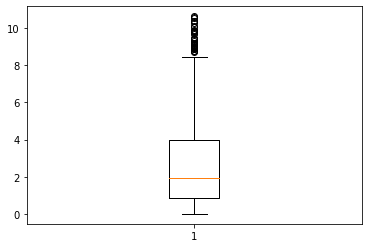

In [186]:
#plt.boxplot(estadias_urg)
s = np.std(estadias_urg, ddof=1)
mu = np.mean(estadias_urg)
iqr = stats.iqr(estadias_urg)
cota_superior = stats.scoreatpercentile(estadias_urg, 75) + 3*iqr
cota_inferior = max(stats.scoreatpercentile(estadias_urg, 75) - 3*iqr, 0)

estadias_urg_filtrada = [x for x in estadias_urg if cota_inferior < x <= cota_superior]

iqr = stats.iqr(estadias_urg_filtrada)
cota_superior_filtrada = stats.scoreatpercentile(estadias_urg_filtrada, 75) + 1.5*iqr
cota_inferior_filtrada = max(stats.scoreatpercentile(estadias_urg_filtrada, 75) - 1.5*iqr, 0)

estadias_urg_filtrada_2 = [x for x in estadias_urg_filtrada if cota_inferior_filtrada < x <= cota_superior_filtrada]


plt.boxplot(estadias_urg_filtrada_2)

In [187]:
print(np.std(estadias_urg_filtrada, ddof=1))
print(np.mean(estadias_urg_filtrada))
print(len(estadias_urg) - len(estadias_urg_filtrada_2))
print(len(estadias_urg))

4.425983006786172
3.879907084785134
464
1765


,sumsquare_error,aic,bic,kl_div
expon,0.191716,541.950869,-11140.227548,inf
chi2,0.234008,547.656125,-10880.313913,inf
lognorm,0.269433,556.450239,-10701.571603,inf
rayleigh,0.532877,556.187036,-9843.978459,inf
cauchy,0.598451,630.122450,-9696.823061,inf


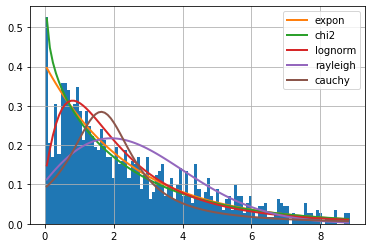

In [180]:
fit_urg = Fitter(estadias_urg_filtrada_2, distributions = get_common_distributions())
fit_urg.fit()
fit_urg.summary()

In [164]:
dic_distribuciones['URG'] = fit_urg.get_best()
dic_distribuciones['URG']

{'expon': {'loc': 0.016666666666666666, 'scale': 2.7776851149861006}}

### Test de bondad de ajuste para las estadias de los div, opr y urg

In [165]:
from scipy import stats

# Escrito acá las distribuciones para no volver a correr el código lento
dic_distribuciones = {}
dic_distribuciones['OPR'] = {'gnnorem': (1.7513217591646353, 2.435311534067437, 0.7090240209156644)}
dic_distribuciones['DIV'] = {'gilbrat': (-2.7780727782429064, 8.426107126901229)}
dic_distribuciones['URG'] = {'expon': {'loc': 0.016666666666666666, 'scale': 2.7776851149861006}}


**Para los tiempos de OPR**     
Vemos que los tiempos de estadía en las salas opr se distribuye de manera generalized normal

In [95]:
estadias_opr = datos_operaciones['DURACION (hrs)']
params_opr_gennorm = dic_distribuciones['OPR']['gennorm']

#obs = stats.gennorm.rvs(opr_gennorm_beta, opr_gennorm_loc, opr_gennorm_scale, size=len(estadias_opr))


In [123]:
data = {
    'tiempo': estadias_opr.value_counts().index, 
    'observed_freq': estadias_opr.value_counts()
}
df_opr = pd.DataFrame(data)

prob_dist = []
for i in range(0,len(df_opr)):
    x = df_opr['tiempo'].iloc[i]
    prob_dist.append(stats.gennorm.pdf(x, *params_opr_gennorm))

df_opr['prob_dist'] = prob_dist
df_opr['prob_dist'] = df_opr['prob_dist'] / df_opr['prob_dist'].sum()
df_opr['expected_freq'] = df_opr['observed_freq'].sum() * df_opr['prob_dist']
df_opr

,tiempo,observed_freq,prob_dist,expected_freq
2.4,2.4,35,0.079435,32.727066
2.8,2.8,32,0.058442,24.078263
2.5,2.5,32,0.078655,32.405697
2.2,2.2,30,0.069080,28.460760
2.3,2.3,30,0.075579,31.138628
2.6,2.6,30,0.073892,30.443335
2.9,2.9,25,0.049553,20.415716
2.7,2.7,21,0.066827,27.532664
2.0,2.0,19,0.052175,21.496053
2.1,2.1,18,0.060991,25.128449


In [97]:
# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
for i in range(0, len(df_opr)):
    O = df_opr['observed_freq'].iloc[i]
    E = df_opr['expected_freq'].iloc[i]
    resultado = (O-E)**2 /E
    chi_square += resultado

print(chi_square)

200.36785807953274


In [126]:
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, len(df_opr['tiempo']) - 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 200.36785807953274  and p value is: 0.0
Null Hypothesis is rejected.


In [108]:
stats.chisquare(df_opr['observed_freq'], f_exp = df_opr['expected_freq'])

Power_divergenceResult(statistic=200.36785807953274, pvalue=1.1078295741844997e-26)

**Para los tiempos de los div**

In [111]:
div_params_gilbrat = dic_distribuciones['DIV']['gilbrat']

In [112]:
df_estadias_div = pd.Series(estadias_div)
tiempos = df_estadias_div.value_counts().index
data = {
    'tiempo': tiempos,
    'observed_freq': df_estadias_div.value_counts()
}

df_div = pd.DataFrame(data, index=data['tiempo'])
prob_dist = []
for i in range(0,len(df_div)):
    x = df_div['tiempo'].iloc[i]
    prob_dist.append(stats.gilbrat.pdf(x, *div_params_gilbrat))

df_div['prob_dist'] = prob_dist
df_div['prob_dist'] = df_div['prob_dist'] / df_div['prob_dist'].sum()
df_div['expected_freq'] = df_div['observed_freq'].sum() * df_div['prob_dist']
df_div

,tiempo,observed_freq,prob_dist,expected_freq
0.000000,0.000000,335,0.018555,10.483431
21.866667,21.866667,2,0.002176,1.229566
2.633333,2.633333,2,0.015983,9.030233
2.550000,2.550000,2,0.016120,9.107559
40.150000,40.150000,2,0.000590,0.333573
...,...,...,...,...
11.966667,11.966667,1,0.005532,3.125828
5.616667,5.616667,1,0.011364,6.420669
9.766667,9.766667,1,0.007026,3.969517
0.050000,0.050000,1,0.018588,10.502272


In [113]:
stats.chisquare(df_div['observed_freq'], f_exp = df_div['expected_freq'])

Power_divergenceResult(statistic=4127325.3937425246, pvalue=0.0)

**Para los tiempos en URG**

In [172]:
urg_params_expon = dic_distribuciones['URG']['expon']
urg_params_expon


{'loc': 0.016666666666666666, 'scale': 2.7776851149861006}

In [189]:
df_estadias_urg = pd.Series(estadias_urg_filtrada)
tiempos = df_estadias_urg.value_counts().index

data = {
    'tiempo': tiempos,
    'observed_freq': df_estadias_urg.value_counts()
}

df_urg = pd.DataFrame(data, index=data['tiempo'])
prob_dist = []
for i in range(0,len(df_urg)):
    x = df_urg['tiempo'].iloc[i]
    prob_dist.append(stats.expon.pdf(x, loc=0.016666666666666666, scale=2.7776851149861006))

df_urg['prob_dist'] = prob_dist
df_urg['prob_dist'] = df_urg['prob_dist'] / df_urg['prob_dist'].sum()
df_urg['expected_freq'] = df_urg['observed_freq'].sum() * df_urg['prob_dist']
df_urg

c:\Users\joaco\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Users\joaco\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,tiempo,observed_freq,prob_dist,expected_freq
0.016667,0.016667,20,0.006796,9.752914
0.033333,0.033333,17,0.006756,9.694570
0.233333,0.233333,11,0.006286,9.021075
0.716667,0.716667,11,0.005282,7.580338
0.500000,0.500000,11,0.005711,8.195296
...,...,...,...,...
3.550000,3.550000,1,0.001905,2.733338
4.950000,4.950000,1,0.001151,1.651208
2.000000,2.000000,1,0.003328,4.775708
2.150000,2.150000,1,0.003153,4.524651


In [176]:
stats.chisquare(df_urg['observed_freq'], f_exp = df_urg['expected_freq'])

Power_divergenceResult(statistic=650.5022654103986, pvalue=2.4147318018233743e-10)

# Ajuste a exponencial para la validación teorica de la simulación
Con estas tasas se realiza el modelo MMK con el que se ve la tasa de ocupación y podemos saber si la simluación debería diverger o no.

,sumsquare_error,aic,bic,kl_div
expon,0.00231,3132.805283,-6997.48966,inf


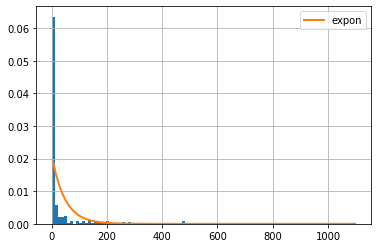

In [122]:
fit_estadias_div_exp = Fitter(estadias_div, distributions=["expon"])
fit_estadias_div_exp.fit()
fit_estadias_div_exp.summary()

In [84]:
fit_estadias_div_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 46.626873156342185}}

,sumsquare_error,aic,bic,kl_div
expon,0.04383,1799.537581,-18699.935716,inf


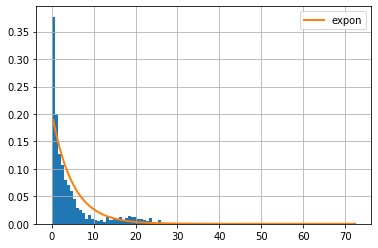

In [85]:
fit_estadias_urg_exp = Fitter(estadias_urg, distributions=["expon"])
fit_estadias_urg_exp.fit()
fit_estadias_urg_exp.summary()

In [86]:
fit_estadias_urg_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 4.912511803588291}}

,sumsquare_error,aic,bic,kl_div
expon,29.8361,350.31629,-1069.583318,inf


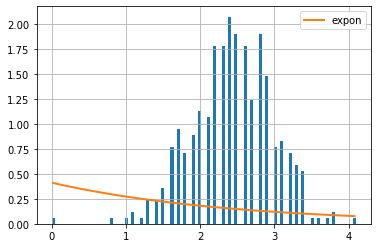

In [91]:
fit_estadias_opr_exp = Fitter(datos_operaciones['DURACION (hrs)'], distributions=["expon"])
fit_estadias_opr_exp.fit()
fit_estadias_opr_exp.summary()

In [92]:
fit_estadias_opr_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 2.4310679611650485}}